In [1]:
%cd ..

/Users/vjs/Lab/stacker


### IMPORTS

In [2]:
import numpy as np
from scipy.ndimage.filters import uniform_filter
from scipy import signal
from skimage.transform import resize
import ipywidgets as widgets
import matplotlib.pyplot as plt
import h5py

from IPython.display import display, clear_output
from ipywidgets import Button, HBox, VBox, Layout
from operator import itemgetter

from dasp.algorithms import *
from dasp.visualizations import *
from examples.h5_handling import *
# from dasp_function_history import hasp_fixed_old

/var/folders/38/_9psl8756xd3hh2kzldw4868d196v6/T/ipykernel_77783/556681489.py:2: DeprecationWarning: Please import `uniform_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import uniform_filter


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

### BUILDING FIXED HASP

#### Step 1: Create a basic signal to apply the algorithm to

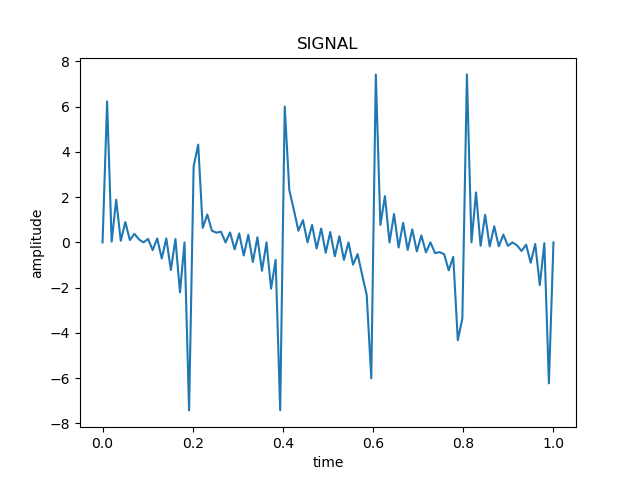

In [4]:
# set variables needed for basic sine wave
base_freq = 5
sample_rate = 100 # samples per second
duration = 1 # duration in seconds
noise = 0
wave_type = "sine"
harmonics = (sample_rate // 2) // base_freq # this is telling us the max harmonics we can have, based on nyquist rate - can ignore for now

# create sine wave, using our custom sine wave creator
sig, time = sine_wave_creator(
    base_freq=base_freq,
    sample_rate=sample_rate,
    duration=duration,
    harmonics=harmonics,
    noise=noise,
    wave_type=wave_type,
    num_signals=1
)

# display settings
sig_fig, sig_ax = plt.subplots()
sig_ax.set_title("SIGNAL")
sig_ax.set_xlabel("time")
sig_ax.set_ylabel("amplitude")
sig_fig.canvas.header_visible = False
# display
sig_ax.plot(time, sig)

#### Step 2: Create an FFT of the generated signal

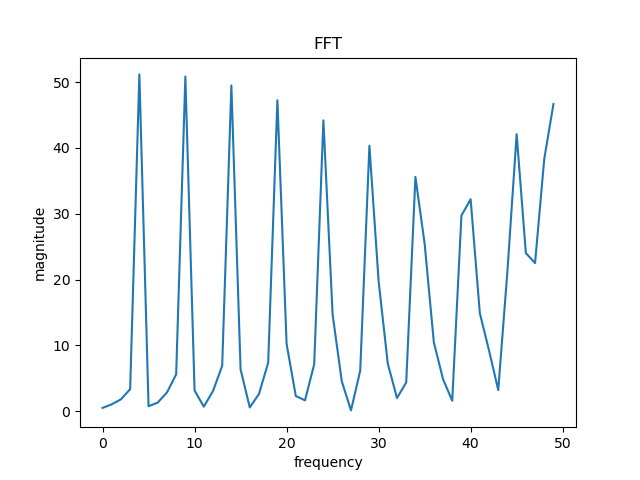

In [5]:
# create FFT using our built in FFT generator
fft = gen_fft(sig)

# display settings
fft_fig, fft_ax = plt.subplots()
fft_ax.set_title("FFT")
fft_ax.set_xlabel("frequency")
fft_ax.set_ylabel("magnitude")
fft_fig.canvas.header_visible = False

# display
fft_ax.plot(fft)

# NOTE: this is probably why they removed the last point instead of the first - it shifts down by 1, hover over frequency spikes

### HASP Overview
At a high level, the baseline (fixed) HASP Algorithm logically operates by:
1. Navigating to the frequency center of each harmonic, within the FFT (in our case these are multiples of the base frequency - example to follow)
    - For this example using a generated (clean) sine waveform, each peak is a harmonic of the base frequency
2. Grouping each frequency center with its surrounding points, trying to equally grab the same number of points from the left and right
    - The number of points is determined by the bandwidth variable
    - ex. if your bandwidth is 3 you would grab 1 from the left of center, the center point itself, and one from the right of center
3. Stacking each set of grouped points on top of each other, and displaying as a color map

We will walk through each of these steps individually as a basic example, then add in the caveats to make it more robust

#### Step 3: Navigate to the frequency center within the FFT

In [6]:
# round FFT points, for ease of viewing
fft = np.round(fft, 1)

# reshape to show each harmonic
print(fft.reshape(harmonics, base_freq))

[[ 0.5  1.   1.8  3.3 51.2]
 [ 0.7  1.3  2.8  5.6 50.8]
 [ 3.1  0.7  3.   6.9 49.5]
 [ 6.4  0.6  2.6  7.4 47.2]
 [10.2  2.3  1.6  7.1 44.2]
 [14.7  4.5  0.1  6.1 40.3]
 [19.7  7.2  2.   4.4 35.6]
 [25.5 10.5  4.9  1.6 29.7]
 [32.2 14.9  9.2  3.2 21.3]
 [42.1 24.  22.5 38.3 46.7]]


These are the contents of the fft, reshaped for convenient viewing - in the above matrix, we can see the numbers spike every 5 points (right most column), as expected with the base frequency 5

First, let's simply add these center points to an array - which we know will be at every 5th point, and we will have a center frequency at each harmonic

In [7]:
# create a list of only the frequency center points from the FFT
# we can only have a number of frequency centers up to the maximum number of harmonics

freq_centers = []


for point in range(1,harmonics+1):
    freq_centers.append(fft[point*base_freq-1]) # -1 because array index is 0 based
    # ex. fft[1*5-1] = fft[4], fft[2*5-1] = fft[9], etc
    
freq_centers

[np.float64(51.2),
 np.float64(50.8),
 np.float64(49.5),
 np.float64(47.2),
 np.float64(44.2),
 np.float64(40.3),
 np.float64(35.6),
 np.float64(29.7),
 np.float64(21.3),
 np.float64(46.7)]

#### Step 4/5: Group the frequency centers with the surrounding points and stack

In [8]:
# define bandwidth
bandwidth = 3
hasp_array = []

for point in range(1, harmonics+1):
    
    # after navigating to the center frequency, get the starting index of what the bandwidth will encompass
    min_bw = int(np.floor((point * base_freq) - (bandwidth / 2))) # ex. (1 * 5) - (3 / 2) = 5 - 1.5 = 3.5, floor = 3
    # repeat for ending index of bandwidth
    max_bw = int(np.floor((point * base_freq) + (bandwidth / 2))) # ex. (1 * 5) + (3 / 2) = 5 + 1.5 = 6.5, floor = 6
    
    # append group to array
    hasp_array.append(fft[min_bw:max_bw])

    
hasp_array

[array([ 3.3, 51.2,  0.7]),
 array([ 5.6, 50.8,  3.1]),
 array([ 6.9, 49.5,  6.4]),
 array([ 7.4, 47.2, 10.2]),
 array([ 7.1, 44.2, 14.7]),
 array([ 6.1, 40.3, 19.7]),
 array([ 4.4, 35.6, 25.5]),
 array([ 1.6, 29.7, 32.2]),
 array([ 3.2, 21.3, 42.1]),
 array([38.3, 46.7])]

From the above output, we can see the frequency centers BUT there is an obvious issue we are going to go ahead and address:
1. The last frequency center is also the final point in this FFT and therefore has no right side to its bandwidth
    - To fix this, we will make the calculation up front to determine how many full rows (harmonics) we can have

Additionally, we are going to add a few general code improvements:
1. Efficiency improvement by prefilling a zeros matrix and editting rather than appending to an array
2. Raise an error if bandwidth will overlap
3. Allow the user to input the maximum number of harmonics they want to see in the algorithm
4. Turning this into a function

*Above is meant to serve as an example of why the total harmonics in the end is not necessarily equal to the max harmonics*

In [9]:
def hasp_example(fft, bandwidth, freq_center, max_harmonics = -1):
    
    # -- logic to ensure full bandwidth -- #
    # remove half of the bandwidth from the total size of the fft
    # divide by the number of points between each harmonic, and get the floor
    # this ensures we are only going up to the last harmonic which contains a full right half
    max_possible_harmonics = int(np.floor((fft.size - bandwidth / 2) / (freq_center)))
    
    # if the user input more harmonics than what's possible, or no harmonics, default to max
    if ((max_harmonics > max_possible_harmonics) | (max_harmonics < 1)):
        max_harmonics = max_possible_harmonics
    
    # raise an error if the user input a bandwidth size that would cause overlap
    if bandwidth > base_freq:
        raise ValueError("Bandwidth cannot be greater than frequency center")

    # filling a predefined template is more efficient than appending to an empty array for large data sets
    hasp_array = np.zeros(shape=(max_harmonics, bandwidth))

    for point in range(1, max_harmonics+1):

        # after navigating to the center frequency, get the starting index of what the bandwidth will encompass
        min_bw = int(np.floor((point * freq_center) - (bandwidth / 2))) # ex. (1 * 5) - (3 / 2) = 5 - 1.5 = 3.5, floor = 3
                                                                      # ex. (1 * 5) - (4 / 2) = 5 - 2 = 3, floor = 3
        # repeat for ending index of bandwidth
        max_bw = int(np.floor((point * freq_center) + (bandwidth / 2))) # ex. (1 * 5) + (3 / 2) = 5 + 1.5 = 6.5, floor = 6
                                                                      # ex. (1 * 5) + (4 / 2) = 5 - 2 = 7, floor = 7
        # get the individual segment
        freq_bin = fft[min_bw:max_bw]
        # assign to appropriate section within array
        hasp_array[point-1, :] = freq_bin
        
    return hasp_array
    
hasp_array = hasp_example(fft, bandwidth = 3, freq_center = 5)

hasp_array

array([[ 3.3, 51.2,  0.7],
       [ 5.6, 50.8,  3.1],
       [ 6.9, 49.5,  6.4],
       [ 7.4, 47.2, 10.2],
       [ 7.1, 44.2, 14.7],
       [ 6.1, 40.3, 19.7],
       [ 4.4, 35.6, 25.5],
       [ 1.6, 29.7, 32.2],
       [ 3.2, 21.3, 42.1]])

### This is the basis of the algorithm!
#### Let's make a quick display to both highlight what we are looking at within the FFT and display the actual visualization for the HASP algorithm
(...then we will make it more robust)

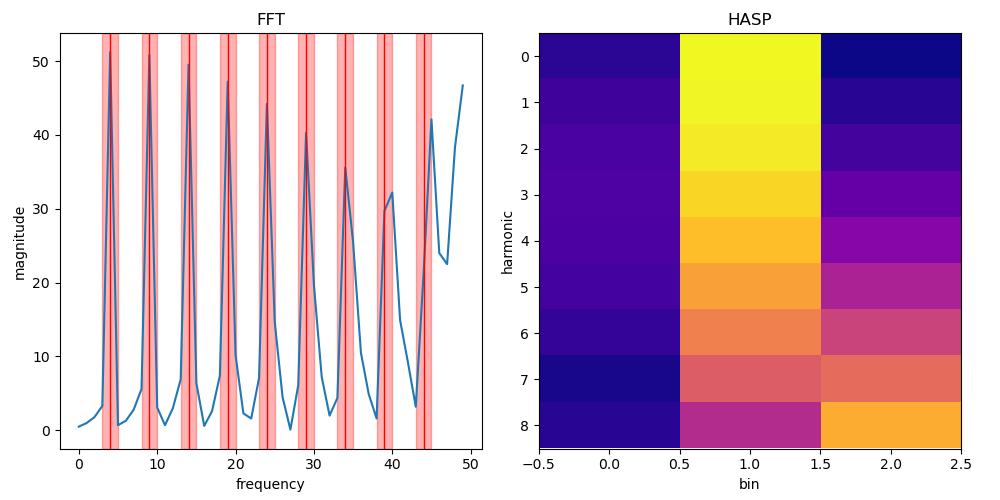

In [10]:
# its safe to ignore this code and just view the figure

# close plot
# plt.close(base_ex_fig)

def fft_hasp_viewer(fft, hasp_array, bandwidth):
    # make figure
    base_ex_fig, base_ex_ax = plt.subplots(1, 2)
    
    max_harmonics = int(np.floor((fft.size - bandwidth / 2) / (base_freq)))

    # ---------- FFT ---------- #
    harmonic_centers = []

    # set solid vertical line at frequency centers
    for i in range(max_harmonics):
        harmonic_centers.append((i + 1) * (base_freq) - 1)

    # display settings
    base_ex_fig.set_figwidth(10)
    base_ex_fig.set_figheight(5)
    base_ex_fig.canvas.header_visible = False
    plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)
    base_ex_ax[0].plot(fft)
    base_ex_ax[0].set_title("FFT")
    base_ex_ax[0].set_xlabel("frequency")
    base_ex_ax[0].set_ylabel("magnitude")

    # set solid vertical line at frequency centers
    [base_ex_ax[0].axvline(_x, linewidth=1, color="red") for _x in harmonic_centers]

    # create transparently filled area as bandwidth
    for i in range(max_harmonics):
        if bandwidth%2 == 0:
            delta_min = int(((i + 1) * base_freq) - (bandwidth / 2))+1
            delta_max = int(((i + 1) * base_freq) + (bandwidth / 2))
        else:
            delta_min = int(np.ceil(((i + 1) * base_freq) - (bandwidth / 2)))
            delta_max = int(np.floor(((i + 1) * base_freq) + (bandwidth / 2)))
            
        base_ex_ax[0].axvspan(delta_min-1, delta_max-1, color="red", alpha=0.3)

    # ---------- HASP ---------- #

    base_ex_ax[1].imshow(hasp_array, aspect="auto", cmap="plasma", interpolation="none")
    base_ex_ax[1].set_title("HASP")
    base_ex_ax[1].set_xlabel("bin")
    base_ex_ax[1].set_ylabel("harmonic")
    
fft_hasp_viewer(fft, hasp_array, bandwidth =3)

# why does hasp start at -0.5?


#### Wonderful, now we can see the range we are pulling from on the FFT, and what it looks like stacked on top of itself as a heatmap


### Step 7: Adjust step size for navigating to the frequency center inside the FFT


Currently, our HASP algorithm only works if we have taken exactly 1 second, which allows us to use the assumption that the center point in the FFT will be at indices that are multiples of the base frequency
    
See below, changing the duration from 1 to 2 (doubling the size), as an example for why this does not work with our current method

In [11]:
# set variables needed for basic sine wave
base_freq = 5
sample_rate = 100
duration = 2 # duration
noise = 0
wave_type = "sine"
harmonics = (sample_rate // 2) // base_freq # this is telling us the max harmonics we can have, based on nyquist rate - can ignore for now

# create sine wave, using our custom sine wave creator
sig2, time2 = sine_wave_creator(
    base_freq=base_freq,
    sample_rate=sample_rate,
    duration=duration,
    harmonics=harmonics,
    noise=noise,
    wave_type=wave_type,
    num_signals=1
)

# create fft
new_fft = gen_fft(sig2)

#create HASP from function we made in step 4/5
hasp_array2 = hasp_example(new_fft, bandwidth = 3, freq_center = 5)

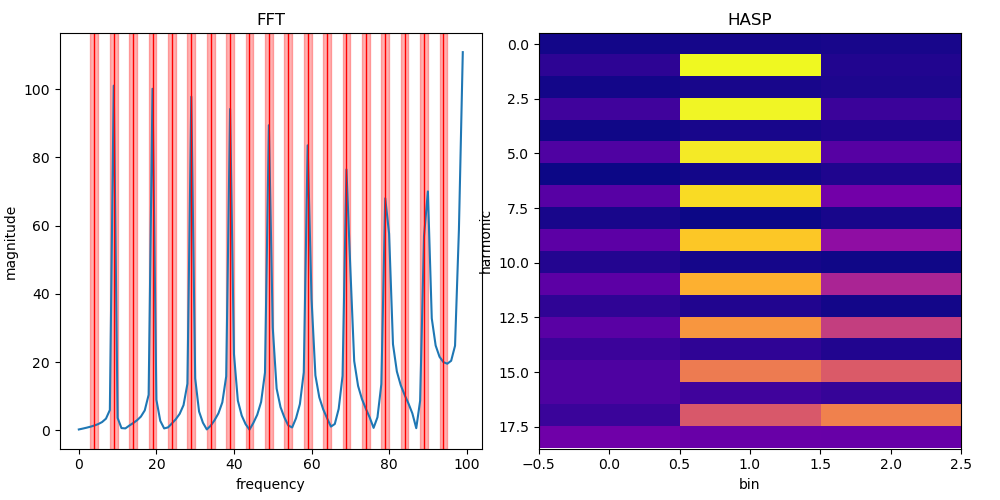

In [12]:
fft_hasp_viewer(new_fft, hasp_array2, bandwidth = 3)

The reason this happens is the base frequency is still 5, however, the FFT size has doubled because we added another second.\
Takeaway - we can no longer use the base frequency as our step size to get to the center frequency in the FFT space
- See the comparison below of the original FFT to the new FFT, which only changed the number of seconds

In [13]:
orig_fft_periods = 1
new_fft_periods = 2

# round FFT points, for ease of viewing
new_fft = np.round(new_fft)

# reshape to show each harmonic
print(fft.reshape(harmonics, base_freq * orig_fft_periods))
print(new_fft.reshape(harmonics, base_freq * new_fft_periods))

[[ 0.5  1.   1.8  3.3 51.2]
 [ 0.7  1.3  2.8  5.6 50.8]
 [ 3.1  0.7  3.   6.9 49.5]
 [ 6.4  0.6  2.6  7.4 47.2]
 [10.2  2.3  1.6  7.1 44.2]
 [14.7  4.5  0.1  6.1 40.3]
 [19.7  7.2  2.   4.4 35.6]
 [25.5 10.5  4.9  1.6 29.7]
 [32.2 14.9  9.2  3.2 21.3]
 [42.1 24.  22.5 38.3 46.7]]
[[  0.   0.   1.   1.   1.   2.   2.   3.   6. 101.]
 [  4.   1.   1.   1.   2.   3.   4.   6.  10. 100.]
 [  9.   3.   1.   1.   2.   3.   5.   7.  14.  98.]
 [ 15.   6.   2.   0.   1.   3.   5.   8.  16.  94.]
 [ 22.   9.   4.   2.   0.   2.   5.   8.  17.  89.]
 [ 30.  12.   7.   4.   1.   1.   4.   8.  17.  83.]
 [ 39.  16.  10.   6.   4.   1.   2.   6.  16.  76.]
 [ 48.  20.  13.   9.   6.   4.   1.   4.  14.  68.]
 [ 58.  25.  17.  13.  10.   8.   5.   1.   9.  57.]
 [ 70.  33.  25.  22.  20.  20.  20.  25.  59. 111.]]


To fix this, we need to adjust our step size to navigate to the center frequencies - and to allow our algorithm to be as dynamic as possible, assume we will not know the number of samples beforehand or size of the full signal beforehand

For this, we can leverage the knowledge that the real FFT size will always be 1/2 the size of the input signal, and we will depend on user input to tell us the sample rate - using these 2 numbers, we can calculate how many samples were taken and determine the appropriate step size

In [14]:
real_sample_rate = sample_rate / 2 # number of points from a sample in the real frequency domain

fc_multiple = new_fft.size / real_sample_rate # duration in seconds
    
bw_pnts = np.ceil(bandwidth * fc_multiple) # adjust bandwidth size to match input as hertz

fc_index = np.ceil(base_freq * fc_multiple)  # index for the frequency center

print("new_fft.size: ", new_fft.size)
print("real_sample_rate: ", real_sample_rate)
print("fc_multiple: ", fc_multiple)
print("bw_pnts: ", bw_pnts)
print("fc_index: ", fc_index)

new_fft.size:  100
real_sample_rate:  50.0
fc_multiple:  2.0
bw_pnts:  6.0
fc_index:  10.0


Take a second to make sure the numbers above make sense:
* **fft size** has doubled from 50 to 100, because we doubled the duration of the signal
* **real_sample_rate** tells us the number of points in the real frequency domain, based on our sample rate
    - if sample rate is the number of points in the entire frequency domain, sample rate / 2 would be the number of points in the real frequency domain which is what our fft uses
* **fc_multiple** is the multiple used in combination with the harmonic number and frequency center (base_freq in our case) to find the center indices
    - i.e. if number of points in fft is 2 * real sample rate, we need to go index (2 * harmonic * frequency_center) to get to the frequency center bins - fc_multiple being the 2
* **bw_points** tells us the new number of points to use for the bandwidth so it matches the user input bandwidth size in hz
* **fc_index** tells us the exact index for the frequency center

now let's add this logic to the hasp function

In [15]:
def hasp_example2(sample_rate, fft, bandwidth, freq_center, max_harmonics = -1):
    
    # adjust step size
    real_sample_rate = sample_rate / 2 # number of points from a sample in the real frequency domain
    fc_multiple = fft.size / real_sample_rate # how many samples (periods)
    bw_points = int(np.ceil(bandwidth * fc_multiple)) # adjust bandwidth size to match input as hertz
    fc_index = np.ceil(freq_center * fc_multiple)  # index for the frequency center
    
    # raise an error if the user input a bandwidth size that would cause overlap
    if bandwidth > 2 * freq_center:
        raise ValueError("Bandwidth cannot be greater than 2x frequency center")
    
    # how many harmonics can we have based on fft and bandwidth size
    max_possible_harmonics = int(np.floor((fft.size - bw_points / 2) / (fc_index)))
    
    # if the user input more harmonics than what's possible, or no harmonics, default to max
    if ((max_harmonics > max_possible_harmonics) | (max_harmonics < 1)):
        max_harmonics = max_possible_harmonics
    
    # shape/fill zero array
    hasp_array = np.zeros(shape=(max_harmonics, bw_points)) #fill zero array
    
    for point in range(1, max_harmonics+1):

        # after navigating to the center frequency, get the starting index of what the bandwidth will encompass
        min_bw = int(np.floor((point * fc_index) - (bw_points / 2))) 
        # repeat for ending index of bandwidth
        max_bw = int(np.floor((point * fc_index) + (bw_points / 2))) 

        # get the individual segment
        freq_bin = fft[min_bw:max_bw]
        # assign to appropriate section within array
        hasp_array[point-1, :] = freq_bin
        
    return hasp_array

#hasp_array3 = hasp_example2(sample_rate = sample_rate, fft = new_fft, bandwidth = 3, freq_center = base_freq)
hasp_array3 = hasp_example2(sample_rate = 100, fft = new_fft, bandwidth = 3, freq_center = 5)
hasp_array3

array([[  3.,   6., 101.,   4.,   1.,   1.],
       [  6.,  10., 100.,   9.,   3.,   1.],
       [  7.,  14.,  98.,  15.,   6.,   2.],
       [  8.,  16.,  94.,  22.,   9.,   4.],
       [  8.,  17.,  89.,  30.,  12.,   7.],
       [  8.,  17.,  83.,  39.,  16.,  10.],
       [  6.,  16.,  76.,  48.,  20.,  13.],
       [  4.,  14.,  68.,  58.,  25.,  17.],
       [  1.,   9.,  57.,  70.,  33.,  25.]])

We also need to adjust the viewer for this logic - feel free to skip this block

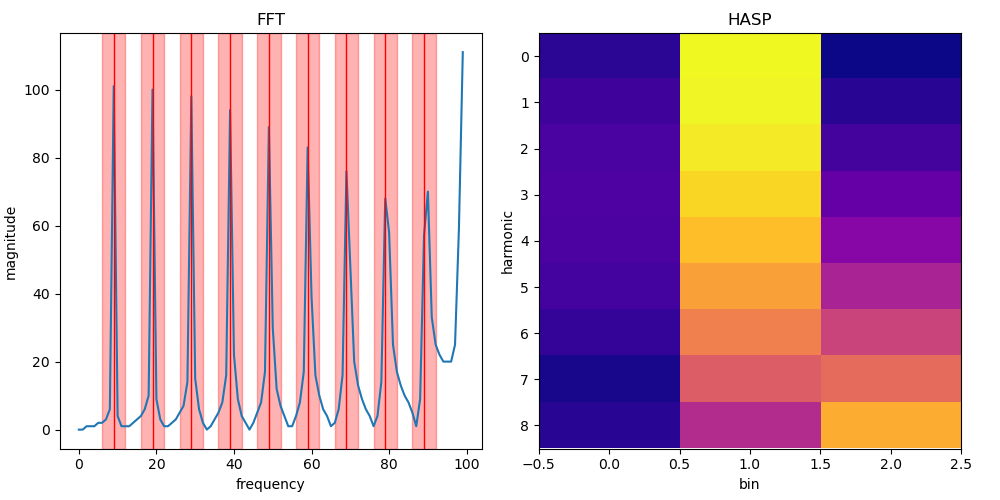

In [16]:

def fft_hasp_viewer2(fft_v, hasp_array_v, bandwidth_v):
    # make figure
    base_ex_fig2, base_ex_ax2 = plt.subplots(1, 2)

    # step size adjustments
    real_sample_rate = sample_rate / 2 # number of points from a sample in the real frequency domain
    fc_multiple = fft_v.size / real_sample_rate # 
    bw_pnts = np.ceil(bandwidth_v * fc_multiple) # adjust bandwidth size to match input as hertz
    fc_index = np.ceil(base_freq * fc_multiple)  # index for the frequency center

    
    max_harmonics = int(np.floor((fft_v.size - bw_pnts / 2) / (fc_index)))
    
    # ---------- FFT ---------- #
    harmonic_centers = []

    # set solid vertical line at frequency centers
    for i in range(max_harmonics):
        harmonic_centers.append((i + 1) * (fc_index) - 1)

    # display settings
    base_ex_fig2.set_figwidth(10)
    base_ex_fig2.set_figheight(5)
    base_ex_fig2.canvas.header_visible = False
    plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)
    base_ex_ax2[0].plot(fft_v)
    base_ex_ax2[0].set_title("FFT")
    base_ex_ax2[0].set_xlabel("frequency")
    base_ex_ax2[0].set_ylabel("magnitude")

    # set solid vertical line at frequency centers
    [base_ex_ax2[0].axvline(_x, linewidth=1, color="red") for _x in harmonic_centers]

    # create transparently filled area as bandwidth
    for i in range(max_harmonics):
        if bandwidth%2 == 0:
            delta_min = int(((i + 1) * fc_index) - (bw_pnts / 2))+1
            delta_max = int(((i + 1) * fc_index) + (bw_pnts / 2))
        else:
            delta_min = int(np.ceil(((i + 1) * fc_index) - (bw_pnts / 2)))
            delta_max = int(np.floor(((i + 1) * fc_index) + (bw_pnts / 2)))
            
        base_ex_ax2[0].axvspan(delta_min-1, delta_max-1, color="red", alpha=0.3)

    # ---------- HASP ---------- #

    base_ex_ax2[1].imshow(hasp_array, aspect="auto", cmap="plasma", interpolation="none")
    base_ex_ax2[1].set_title("HASP")
    base_ex_ax2[1].set_xlabel("bin")
    base_ex_ax2[1].set_ylabel("harmonic")
    
fft_hasp_viewer2(new_fft, hasp_array, bandwidth_v = 3)

wonderful, now our hasp algorithm is dynamic enough to handle an unknown duration - as long as we know the sample rate!

### Step 8: Add finishing touches for image output
    - row normalization
    - image normalization

In [17]:
def zmuv_row_norm(row: np.ndarray) -> np.ndarray:
    """Calculates Zero Mean and Unit Variance (ZMUV) of input row argument

    Args:
        row (np.ndarray): A list of values to be normalized

    Returns:
        np.ndarray: normalized array.

    Note:
        A ZMUV normalized image, in addition to contrast enhancement, helps to speed up model
    """

    # ZMUV = (value - mean) / variance
    row = (row - np.mean(row)) / np.var(row, ddof=1)

    return row


def std_image_filter_2d(image: np.ndarray) -> np.ndarray:
    """Normalizes 2D image with standard deviation filter

    Args:
        image (np.ndarray): The image to be normalized

    Returns:
        np.ndarray: normalized image
    """

    # uniform filter replaces the value of a pixel by the mean value of an
    #   area centered at the pixel
    c1 = uniform_filter(image, mode="reflect")
    c2 = uniform_filter(image * image, mode="reflect")

    # standard deviation = sqrt((sum(x - mean(x))^2)/(n-1))
    image = np.sqrt(c2 - c1 * c1)

    return image

### FINAL FIXED HASP FUNCTION

In [18]:
def hasp_fixed(
    sample_rate: int,
    fft: np.ndarray,
    bandwidth: int,
    freq_center: int,
    use_row_norm: bool,
    use_im_norm: bool,
    max_harmonics=-1,
) -> np.ndarray:
    """Fixed HASP (Harmonically Aligned Signal Projection) algorithm generates a HASP array.

    Args:
        sample_rate (int): Rate at which the the raw time domain signal was acquired or generated.
        fft (np.ndarray): The Fast Fourier Transform of the signal.
        bandwidth (int): How many hertz to include around the frequency center.
        freq_center: The frequency center of the raw time domain signal.
        use_row_norm (bool): Whether to normalize across each FFT individually.
        use_im_norm (bool): Whether to normalize the entire final image.
        max_harmonics: The upper limit of harmonics to include in final HASP array.

    Returns:
        np.ndarray: The fixed HASP array.
    """

    # adjust step size
    # number of points from a sample in the real frequency domain
    real_sample_rate = sample_rate / 2
    # how many samples (periods)
    fc_multiple = fft.size / real_sample_rate
    # adjust bandwidth size to match input as hertz
    bw_points = int(np.ceil(bandwidth * fc_multiple))
    # index for the frequency center
    fc_index = np.ceil(freq_center * fc_multiple)

    # raise an error if the user input a bandwidth size that would cause overlap
    if bandwidth > freq_center:
        raise ValueError("Bandwidth cannot be greater than frequency center")

    # how many harmonics can we have based on fft and bandwidth size
    max_possible_harmonics = int(np.floor((fft.size - bw_points / 2) / (fc_index)))

    # if the user input more harmonics than what's possible, or no harmonics, default to max
    if (max_harmonics > max_possible_harmonics) | (max_harmonics < 1):
        max_harmonics = max_possible_harmonics

    # shape/fill zero array
    hasp_array = np.zeros(shape=(max_harmonics, bw_points))  # fill zero array

    # itterate through fft, grab points around each frequency center, stack on top of each other
    for point in range(1, max_harmonics + 1):

        # after navigating to the center frequency,
        # get the starting index of what the bandwidth will encompass
        min_bw = int(np.floor((point * fc_index) - (bw_points / 2)))
        # repeat for ending index of bandwidth
        max_bw = int(np.floor((point * fc_index) + (bw_points / 2)))

        # get the individual segment
        fft_row = fft[min_bw:max_bw]

        # normalize row if wanted
        if use_row_norm:
            fft_row = zmuv_row_norm(fft_row)

        # assign to appropriate section within array
        hasp_array[point - 1, :] = fft_row

    # normalize entire image if wanted
    if use_im_norm:
        hasp_array = std_image_filter_2d(hasp_array)

    return hasp_array

### DECIMATING AND INTERPOLATING VARIATIONS OF HASP

These variations of HASP algorithm deviate just slightly from Fixed HASP, but now instead of having a fixed number of points around the center frequency as our bandwidth, we allow the number of points to grow with the harmonics BUT either downsample back to the minimum bandwidth size (decimating) or upsample to the maximum bandwidth size (interpolating)

- Decimating = down sampling, or artifically reducing the sampling frequency
- Interpolating = up sampling, or artificially increasing the sampling frequency

See below example of:
- FFT before any changes
- HASP without fixing, downsampling, or upsampling (showing the increased size at each harmonic)
- Decimating HASP (showing each bandwidth is reduced to the minimum size, with updated/resampled values)
- Interpolating HASP (showing each bandwidth is increased to the minimum size, with updated/resampled values)

NOTE: in each example, all comments have been removed except for highlights to the segments that differe from Fixed HASP

For resampling, we use SciPy's resample method with the Signal library - see documentation here:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html

FFT before any changes

In [19]:
# set variables needed for basic sine wave
base_freq = 5
sample_rate = 100
duration = 1
noise = 0
wave_type = "sine"
harmonics = (sample_rate // 2) // base_freq
num_signals = 1

# create sine wave, using our custom sine wave creator
test_sig, test_time = sine_wave_creator(
    base_freq=base_freq,
    sample_rate=sample_rate,
    duration=duration,
    harmonics=harmonics,
    noise=noise,
    wave_type=wave_type,
    num_signals=1
)

test_fft = gen_fft(test_sig)

print('ORIGINAL FFT')
print(test_fft.reshape(harmonics, base_freq))

ORIGINAL FFT
[[ 0.48775918  1.04184879  1.79945976  3.34657416 51.17203415]
 [ 0.74791503  1.30455001  2.84184512  5.59463612 50.84945334]
 [ 3.14748859  0.67947769  3.04998061  6.88438079 49.49249305]
 [ 6.35144698  0.56050621  2.62485436  7.37451569 47.24883608]
 [10.22225285  2.30804256  1.64073664  7.1249808  44.18615156]
 [14.69137521  4.51776521  0.11592263  6.14451206 40.32220093]
 [19.74301362  7.20161103  1.99317175  4.37401948 35.59655798]
 [25.45563764 10.4862132   4.86953472  1.58225361 29.72950016]
 [32.19490977 14.88149522  9.21965012  3.20364682 21.33590141]
 [42.09048829 24.02201425 22.50998639 38.32804386 46.6706326 ]]


HASP process, without Fixing, Decimating, or Interpolating

In [20]:
def hasp_unadjusted(
    sample_rate: int,
    fft: np.ndarray,
    bandwidth: int,
    freq_center: int,
    use_row_norm: bool,
    use_im_norm: bool,
    max_harmonics=-1,
) -> np.ndarray:

    real_sample_rate = sample_rate / 2
    fc_multiple = fft.size / real_sample_rate
    bw_points = int(np.ceil(bandwidth * fc_multiple))
    fc_index = np.ceil(freq_center * fc_multiple)

    if bandwidth > freq_center:
        raise ValueError("Bandwidth cannot be greater than frequency center")

    max_possible_harmonics = int(np.floor(fft.size / (fc_index + bw_points / 2)))

    if (max_harmonics > max_possible_harmonics) | (max_harmonics < 1):
        max_harmonics = max_possible_harmonics

    hasp_array = np.zeros(shape=(max_harmonics, bw_points))

    for point in range(1, max_harmonics + 1):

        # THIS IS THE FIRST CHANGE TO IN COMPARISON TO FIXED HASP
        # adding/substracting the frequency center to the maximun / minimum
        min_bw = int(np.floor((point) * fc_index - (point) * bw_points / 2))
        # fixed hasp: min_bw = int(np.floor((point * fc_index) - (bw_points / 2)))

        max_bw = int(np.floor((point) * fc_index + (point) * bw_points / 2))
        # fixed hasp: max_bw = int(np.floor((point * fc_index) + (bw_points / 2)))

        # COMMENTING OUT FOR COMPARISON
        # resample row to minimum bins (this is decimation)
        # fft_row = signal.resample(fft[min_bw:max_bw], bw_points)

        fft_row = fft[min_bw:max_bw]

        if use_row_norm:
            fft_row = zmuv_row_norm(fft_row)

        # ADDING PRINT FOR DEMONSTRATION
        print('harmonic ' + str(point) + ' size: ' + str(len(fft_row)))
        print(fft_row)
        # hasp_array[point - 1, :] = fft_row

    if use_im_norm:
        hasp_array = std_image_filter_2d(hasp_array)

    return hasp_array

In [21]:
hasp_unadjusted_array = hasp_unadjusted(sample_rate = sample_rate,
                             fft = test_fft,
                             bandwidth = bandwidth,
                             freq_center = base_freq,
                             use_row_norm = False, 
                             use_im_norm = False,
                             max_harmonics = 10)

harmonic 1 size: 3
[ 3.34657416 51.17203415  0.74791503]
harmonic 2 size: 6
[ 2.84184512  5.59463612 50.84945334  3.14748859  0.67947769  3.04998061]
harmonic 3 size: 9
[ 3.14748859  0.67947769  3.04998061  6.88438079 49.49249305  6.35144698
  0.56050621  2.62485436  7.37451569]
harmonic 4 size: 12
[49.49249305  6.35144698  0.56050621  2.62485436  7.37451569 47.24883608
 10.22225285  2.30804256  1.64073664  7.1249808  44.18615156 14.69137521]
harmonic 5 size: 15
[ 2.62485436  7.37451569 47.24883608 10.22225285  2.30804256  1.64073664
  7.1249808  44.18615156 14.69137521  4.51776521  0.11592263  6.14451206
 40.32220093 19.74301362  7.20161103]
harmonic 6 size: 18
[ 2.30804256  1.64073664  7.1249808  44.18615156 14.69137521  4.51776521
  0.11592263  6.14451206 40.32220093 19.74301362  7.20161103  1.99317175
  4.37401948 35.59655798 25.45563764 10.4862132   4.86953472  1.58225361]
harmonic 7 size: 21
[44.18615156 14.69137521  4.51776521  0.11592263  6.14451206 40.32220093
 19.74301362  7.

Decimating HASP

In [22]:
def hasp_decim_demo(
sample_rate: int,
fft: np.ndarray,
bandwidth: int,
freq_center: int,
use_row_norm: bool,
use_im_norm: bool,
max_harmonics=-1,
) -> np.ndarray:

    real_sample_rate = sample_rate / 2
    fc_multiple = fft.size / real_sample_rate
    bw_points = int(np.ceil(bandwidth * fc_multiple))
    fc_index = np.ceil(freq_center * fc_multiple)

    if bandwidth > freq_center:
        raise ValueError("Bandwidth cannot be greater than frequency center")

    max_possible_harmonics = int(np.floor(fft.size / (fc_index + bw_points / 2)))

    if (max_harmonics > max_possible_harmonics) | (max_harmonics < 1):
        max_harmonics = max_possible_harmonics

    hasp_array = np.zeros(shape=(max_harmonics, bw_points))

    for point in range(1, max_harmonics + 1):

        # THIS IS THE FIRST CHANGE TO IN COMPARISION TO FIXED HASP
        # adding/substracting the frequency center to the maximun / minimum
        min_bw = int(np.floor((point) * fc_index - (point) * bw_points / 2))
        # fixed hasp: min_bw = int(np.floor((point * fc_index) - (bw_points / 2)))

        max_bw = int(np.floor((point) * fc_index + (point) * bw_points / 2))
        # fixed hasp: max_bw = int(np.floor((point * fc_index) + (bw_points / 2)))

        # resample row to minimum bins (this is decimation)
        fft_row = signal.resample(fft[min_bw:max_bw], bw_points)

        # ADDING PRINT FOR DEMONSTRATION
        print('harmonic ' + str(point) + ' size: ' + str(len(fft_row)))
        print(fft_row)

        if use_row_norm:
            fft_row = zmuv_row_norm(fft_row)

        hasp_array[point - 1, :] = fft_row

    if use_im_norm:
        hasp_array = std_image_filter_2d(hasp_array)

    return hasp_array

In [23]:
hasp_decim_array = hasp_decim_demo(sample_rate = sample_rate,
                             fft = test_fft,
                             bandwidth = bandwidth,
                             freq_center = base_freq,
                             use_row_norm = False, 
                             use_im_norm = False,
                             max_harmonics = 10)

harmonic 1 size: 3
[ 3.34657416 51.17203415  0.74791503]
harmonic 2 size: 3
[ 3.77788004 27.83043814  1.47312256]
harmonic 3 size: 3
[-1.29186215 17.15275519 10.86082161]
harmonic 4 size: 3
[21.55919027 10.7040982  16.19325952]
harmonic 5 size: 3
[15.37968446 13.5166891  14.19698069]
harmonic 6 size: 3
[ 9.46267959 14.60800235 14.65493483]
harmonic 7 size: 3
[16.72822621 13.99215768 16.68605098]


Interpolating HASP

In [24]:
def hasp_interp_demo(
sample_rate: int,
fft: np.ndarray,
bandwidth: int,
freq_center: int,
use_row_norm: bool,
use_im_norm: bool,
max_harmonics=-1,
) -> np.ndarray:

    real_sample_rate = sample_rate / 2
    fc_multiple = fft.size / real_sample_rate
    bw_points = int(np.ceil(bandwidth * fc_multiple))
    fc_index = np.ceil(freq_center * fc_multiple)

    if bandwidth > freq_center:
        raise ValueError("Bandwidth cannot be greater than frequency center")

    max_possible_harmonics = int(np.floor(fft.size / (fc_index + bw_points / 2)))

    if (max_harmonics > max_possible_harmonics) | (max_harmonics < 1):
        max_harmonics = max_possible_harmonics

    # this would be the maximum number of bins/points in the last possible harmonic
    max_bins = int(max_possible_harmonics * bw_points)

    hasp_array = np.zeros(shape=(max_harmonics, max_bins))

    for point in range(1, max_harmonics + 1):

        # THIS IS THE FIRST CHANGE TO IN COMPARISION TO FIXED HASP
        # adding/substracting the frequency center to the maximun / minimum
        min_bw = int(np.floor((point) * fc_index - (point) * bw_points / 2))
        # fixed hasp: min_bw = int(np.floor((point * fc_index) - (bw_points / 2)))

        max_bw = int(np.floor((point) * fc_index + (point) * bw_points / 2))
        # fixed hasp: max_bw = int(np.floor((point * fc_index) + (bw_points / 2)))

        # resample row to maximum bins (this is interpolation)
        fft_row = signal.resample(fft[min_bw:max_bw], max_bins)

        # ADDING PRINT FOR DEMONSTRATION
        print('harmonic ' + str(point) + ' size: ' + str(len(fft_row)))
        print(fft_row)

        if use_row_norm:
            fft_row = zmuv_row_norm(fft_row)

        hasp_array[point - 1, :] = fft_row

    if use_im_norm:
        hasp_array = std_image_filter_2d(hasp_array)

    return hasp_array

In [25]:
hasp_interp_array = hasp_interp_demo(sample_rate = sample_rate,
                             fft = test_fft,
                             bandwidth = bandwidth,
                             freq_center = base_freq,
                             use_row_norm = False, 
                             use_im_norm = False,
                             max_harmonics = 10)

harmonic 1 size: 21
[  3.34657416  12.59736506  22.36571583  31.78366565  40.01438833
  46.32654806  50.15928174  51.17203415  49.27481782  44.63620872
  37.66836764  28.99041784  19.37343323   9.6719251    0.74791503
  -6.60565952 -11.7354012  -14.18550994 -13.73828282 -10.43345794
  -4.56468349]
harmonic 2 size: 21
[ 2.84184512 -1.37149489 -3.70179309  0.39491823 12.68754001 29.97484741
 45.1028476  50.84945334 44.22579439 28.32262882 10.44655264 -2.194253
 -6.38016146 -3.8947369   0.67947769  3.50082475  3.7232822   3.05894144
  3.40712531  4.74943198  5.14701354]
harmonic 3 size: 21
[ 3.14748859 -3.34457669 -1.55718993  5.39038552  7.03803215  0.32778696
 -3.95005402  6.88438079 30.35927541 48.10087732 44.14691366 21.9461634
  0.5057282  -5.61854032  0.56050621  5.91002558  4.04239284  0.73978296
  3.24621634  9.20206511  9.97434252]
harmonic 4 size: 21
[49.49249305 33.87168618 -0.94426249 -6.858495    7.58290528  5.81078619
 -4.68435818  7.37451569 36.41854592 46.47447545 24.76900

The use for this adjustment is best demonstrated on a larger scale, and with multiple signals - see below demonstration of the Decimating and Interpolating HASP algorithms

As a short summary,
- Decimating loses resolution at higher harmonics
- Interpolating increases resolution at higher harmonics

In [27]:
base_freq = 100
sample_rate = 2000
duration = 1
noise = 0
wave_type = "sine"
harmonics = (sample_rate // 2) // base_freq
num_signals = 2

# create sine wave, using our custom sine wave creator
demo_sig, demo_time = sine_wave_creator(
    base_freq=base_freq,
    sample_rate=sample_rate,
    duration=duration,
    harmonics=harmonics,
    noise=noise,
    wave_type=wave_type,
    num_signals=num_signals
)

In [28]:
hasp_viz(signal = demo_sig, freq_center = base_freq, sample_rate = sample_rate)